## imports

In [10]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
import requests
import json

from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.externals import joblib

from nltk.stem.snowball import SnowballStemmer

from scipy.cluster.hierarchy import ward, dendrogram

import matplotlib.pyplot as plt
%matplotlib inline

import visualisedictionary as vd


## es config

In [2]:

res = requests.get('http://localhost:9200')
print(res.content)

{
  "name" : "Stardust",
  "cluster_name" : "elasticsearch_jm",
  "version" : {
    "number" : "2.1.1",
    "build_hash" : "40e2c53a6b6c2972b3d13846e450e66f4375bd71",
    "build_timestamp" : "2015-12-15T13:05:55Z",
    "build_snapshot" : false,
    "lucene_version" : "5.3.1"
  },
  "tagline" : "You Know, for Search"
}



In [3]:
#connect to our cluster
from elasticsearch import Elasticsearch
es = Elasticsearch([{'host': 'localhost', 'port': 9200}])

In [4]:
print es.count()

{u'count': 43039, u'_shards': {u'successful': 11, u'failed': 0, u'total': 11}}


## es queries

In [5]:
signal_gte_9 = es.search(index="articles", size=1000, body={"query": {
    "range": {
       "signal-importance":{"gte":9}
    }
}})

print len(signal_gte_9['hits']['hits'])

1000


In [6]:
res_all = es.search(index="articles", body={"query": {
        "query" : {
            "match_all" : {},
        }
    }},
    size = 10000
)

print len(res_all['hits']['hits'])

10000


### test es queries for Python microservice

In [7]:
# config
api_base_url = '/api/v1'
es_base_url = {
    'articles': 'http://localhost:9200/articles/article',
}
url = es_base_url['articles']+'/_search'
query = {
  "query" : {
      "match_all" : {},
  },
  "size" : 10
}
resp = requests.post(url, data=json.dumps(query))
data = resp.json()

In [8]:
print type(data)

<type 'dict'>


In [13]:
vd.pprint(data)

- hits
	- hits
	- total
	- max_score
- _shards
	- successful
	- failed
	- total
- took
- timed_out


In [16]:
vd.pprint(data['hits']['hits'])

In [18]:
data

{u'_shards': {u'failed': 0, u'successful': 5, u'total': 5},
 u'hits': {u'hits': [{u'_id': u'8f78fdd9-103a-4e50-83a1-f9cdfa83f29a',
    u'_index': u'articles',
    u'_score': 1.0,
    u'_source': {u'author': u'Liz McMillan',
     u'canonical-source': u'caaf6463-bb6b-422a-848f-fa2c8c74ee5d',
     u'canonical-source-name': u'Sys-Con Italia',
     u'content': u'NEW YORK, Sept. 1, 2015 /PRNewswire/ -- Radiation therapy is a procedure entailing the precise delivery of high doses of radiation to tumors and other relevant anatomical targets. It involves the usage of sophisticated technology to ablate tumors and other abnormalities with noninvasive procedures and high doses of radiation while minimizing the exposure to surrounding healthy tissues. \n\nGamma Knife radiosurgery is a major form of radiation therapy. It is mainly used to treat brain tumors, arteriovenous malformations, trigeminal neuralgia, acoustic neuroma, and pituitary tumors. In Gamma Knife surgery, specialized equipment focuse

In [30]:
for d in data['hits']['hits']:
    vd.pprint(d)
    print d['_source']['topics']

- _score
- _type
- _id
- _source
	- feed
	- tracking-url
	- source-groups
	- topics
	- signal-entities
	- moreover
		- editorial-rank
		- id
		- filename
	- summary
	- title
	- content
	- source
	- signal-importance
	- canonical-source
	- detected-language
	- stanford-entities
	- media-type
	- model-scores
	- story-uuid
	- language-confidences
		- en
	- language
	- url
	- canonical-source-name
	- spotlight-entities
	- author
	- english-language-confidence
	- original-url
	- published
- _index
[]
- _score
- _type
- _id
- _source
	- feed
	- tracking-url
	- source-groups
	- topics
	- signal-entities
	- moreover
		- editorial-rank
		- id
		- filename
	- summary
	- title
	- content
	- source
	- signal-importance
	- canonical-source
	- detected-language
	- stanford-entities
	- media-type
	- model-scores
	- story-uuid
	- language-confidences
		- en
	- language
	- url
	- canonical-source-name
	- spotlight-entities
	- english-language-confidence
	- original-url
	- published
- _index
[]
- _score

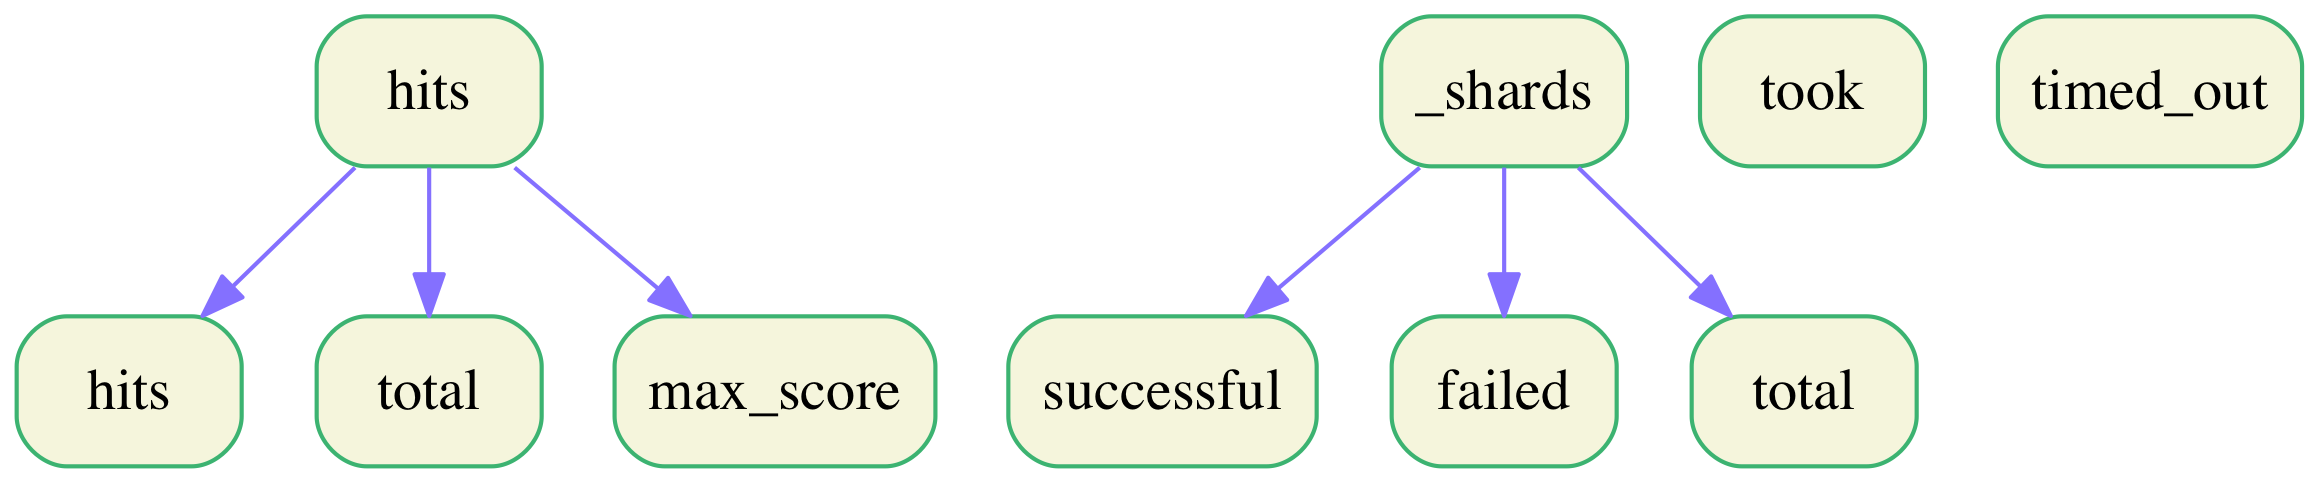

In [18]:
G = vd.KeysGraph(data)
G.draw('./data_graph.png')
from IPython.display import Image
Image('./data_graph.png')

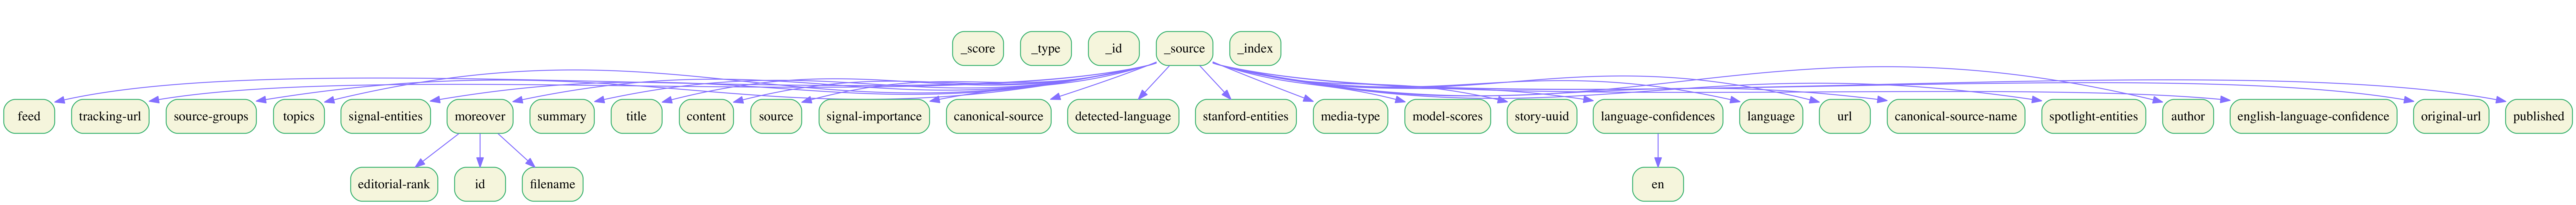

In [19]:
d = data['hits']['hits'][0]
G = vd.KeysGraph(d)
G.draw('./article_graph.png')
Image('./article_graph.png')

In [29]:
print d['_source']['title']
print d['_source']['source']
print d['_source']['author']
print d['_source']['published']
print d['_source']['original-url']
print "Topics: ", d['_source']['topics']

Global Market Study on Gamma Knife: Asia to Witness Highest Growth by 2020
Sys-Con Italia
Liz McMillan
2015-09-01T22:39:23Z
http://it.sys-con.com/node/3438086
Topics:  []


In [21]:
print type(data)

<type 'dict'>


## preprocessing

In [97]:
# assign hits to list of documents
# re-assign results from query
curr_res = res_all
documents = [doc['_source']['content'] for doc in curr_res['hits']['hits']]

In [23]:
print type(res_all)

<type 'dict'>


In [102]:
# stop-wording and stemming
stopwords = nltk.corpus.stopwords.words('english')
stemmer = SnowballStemmer('english')
print stopwords[:10]

[u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u'your']


In [103]:
# tokenizer and stemming words
# http://brandonrose.org/clustering

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [105]:
# create a vocabulary
totalvocab_stemmed = []
totalvocab_tokenized = []
for d in documents:
    allwords_stemmed = tokenize_and_stem(d)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(d)
    totalvocab_tokenized.extend(allwords_tokenized)
    
vocab = pd.DataFrame({'words': totalvocab_tokenized}, index=totalvocab_stemmed)
print "vocab len" + str(vocab.shape[0])

vocab len3804677


In [106]:
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8, max_features=200000, use_idf=True,
                            min_df=0.2, tokenizer=tokenize_and_stem, ngram_range=(1,3))
X = vectorizer.fit_transform(documents)
print X.shape

(10000, 30)


In [155]:
print documents[0]

NEW YORK, Sept. 1, 2015 /PRNewswire/ -- Radiation therapy is a procedure entailing the precise delivery of high doses of radiation to tumors and other relevant anatomical targets. It involves the usage of sophisticated technology to ablate tumors and other abnormalities with noninvasive procedures and high doses of radiation while minimizing the exposure to surrounding healthy tissues. 

Gamma Knife radiosurgery is a major form of radiation therapy. It is mainly used to treat brain tumors, arteriovenous malformations, trigeminal neuralgia, acoustic neuroma, and pituitary tumors. In Gamma Knife surgery, specialized equipment focuses close to 200 tiny beams of radiation on a tumor or other targeted cells. Each beam has minimal effect on the brain tissue and it delivers strong doses of radiation to the targeted tumor cells for treatment. 

Increasing prevalence of cancer, growing aging population, rising number of initiatives undertaken by various government associations, and advanced fea

In [107]:
# get vocab from vectorizer
terms = vectorizer.get_feature_names()

In [110]:
print terms

[u"'s", u'ani', u'come', u'compani', u'day', u'follow', u'help', u'includ', u'inform', u'just', u'like', u'look', u'make', u'need', u'new', u'onli', u'peopl', u'provid', u'report', u'right', u'said', u'say', u'septemb', u'servic', u'state', u'time', u'use', u'work', u'world', u'year']


In [112]:
# make cosine distance matrix
dist = 1 - cosine_similarity(X)

In [114]:
num_clusters = 100
model = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=100, n_init=1)
model.fit(X)
clusters = model.labels_.tolist()
joblib.dump(model, 'kmeans.pkl')

['kmeans.pkl', 'kmeans.pkl_01.npy', 'kmeans.pkl_02.npy']

In [116]:
print "Documents length", len(documents)
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print "Cluster %d:" % i
    for ind in order_centroids[i, :15]:
        print ' %s' % terms[ind],
    print

Documents length 10000
Top terms per cluster:
Cluster 0:
 state  said  report  say  peopl  year  's  new  day  make  ani  onli  use  time  like
Cluster 1:
 's  year  septemb  said  say  report  includ  time  follow  new  world  peopl  come  make  use
Cluster 2:
 septemb  's  day  said  year  new  world  report  peopl  includ  need  come  follow  compani  help
Cluster 3:
 year  world  ani  come  compani  day  follow  help  includ  inform  just  like  look  make  need
Cluster 4:
 said  time  work  's  follow  like  just  year  new  report  ani  need  use  say  includ
Cluster 5:
 compani  inform  's  septemb  new  includ  provid  ani  right  servic  time  follow  report  use  state
Cluster 6:
 new  's  look  just  use  year  follow  septemb  come  day  make  compani  includ  like  world
Cluster 7:
 say  like  make  just  look  come  time  new  work  peopl  year  onli  use  day  right
Cluster 8:
 septemb  new  's  say  said  year  report  day  make  like  use  need  peopl  time  work
Clust

{0: 32, 1: 32, 2: 20, 3: 57, 4: 8, 5: 83, 6: 113, 7: 51, 8: 11, 9: 84, 10: 50, 11: 83, 12: 56, 13: 279, 14: 181, 15: 36, 16: 935, 17: 80, 18: 58, 19: 431, 20: 26, 21: 47, 22: 62, 23: 128, 24: 57, 25: 13, 26: 35, 27: 47, 28: 337, 29: 52, 30: 26, 31: 47, 32: 114, 33: 108, 34: 22, 35: 26, 36: 126, 37: 38, 38: 175, 39: 69, 40: 11, 41: 162, 42: 58, 43: 192, 44: 43, 45: 48, 46: 53, 47: 45, 48: 67, 49: 36, 50: 28, 51: 134, 52: 162, 53: 50, 54: 37, 55: 124, 56: 120, 57: 17, 58: 201, 59: 40, 60: 13, 61: 9, 62: 20, 63: 52, 64: 17, 65: 15, 66: 15, 67: 51, 68: 63, 69: 73, 70: 86, 71: 39, 72: 27, 73: 46, 74: 42, 75: 89, 76: 61, 77: 54, 78: 39, 79: 47, 80: 15, 81: 1968, 82: 9, 83: 25, 84: 96, 85: 60, 86: 254, 87: 109, 88: 33, 89: 64, 90: 37, 91: 23, 92: 25, 93: 46, 94: 49, 95: 184, 96: 55, 97: 38, 98: 59, 99: 30}
<type 'list'>   <type 'list'>


<Container object of 100 artists>

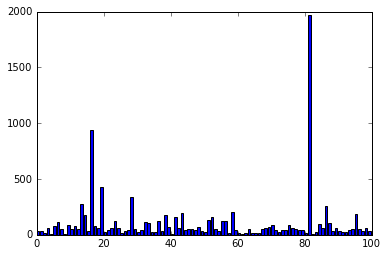

In [90]:


label_counts = {}
for label in model.labels_:
    try:
        label_counts[label] +=1
    except:
        label_counts[label] = 0
        
print label_counts
print type(label_counts.keys()), " ", type(label_counts.values())
        
plt.bar(label_counts.keys(), label_counts.values())

## Hierarchical Document Clustering

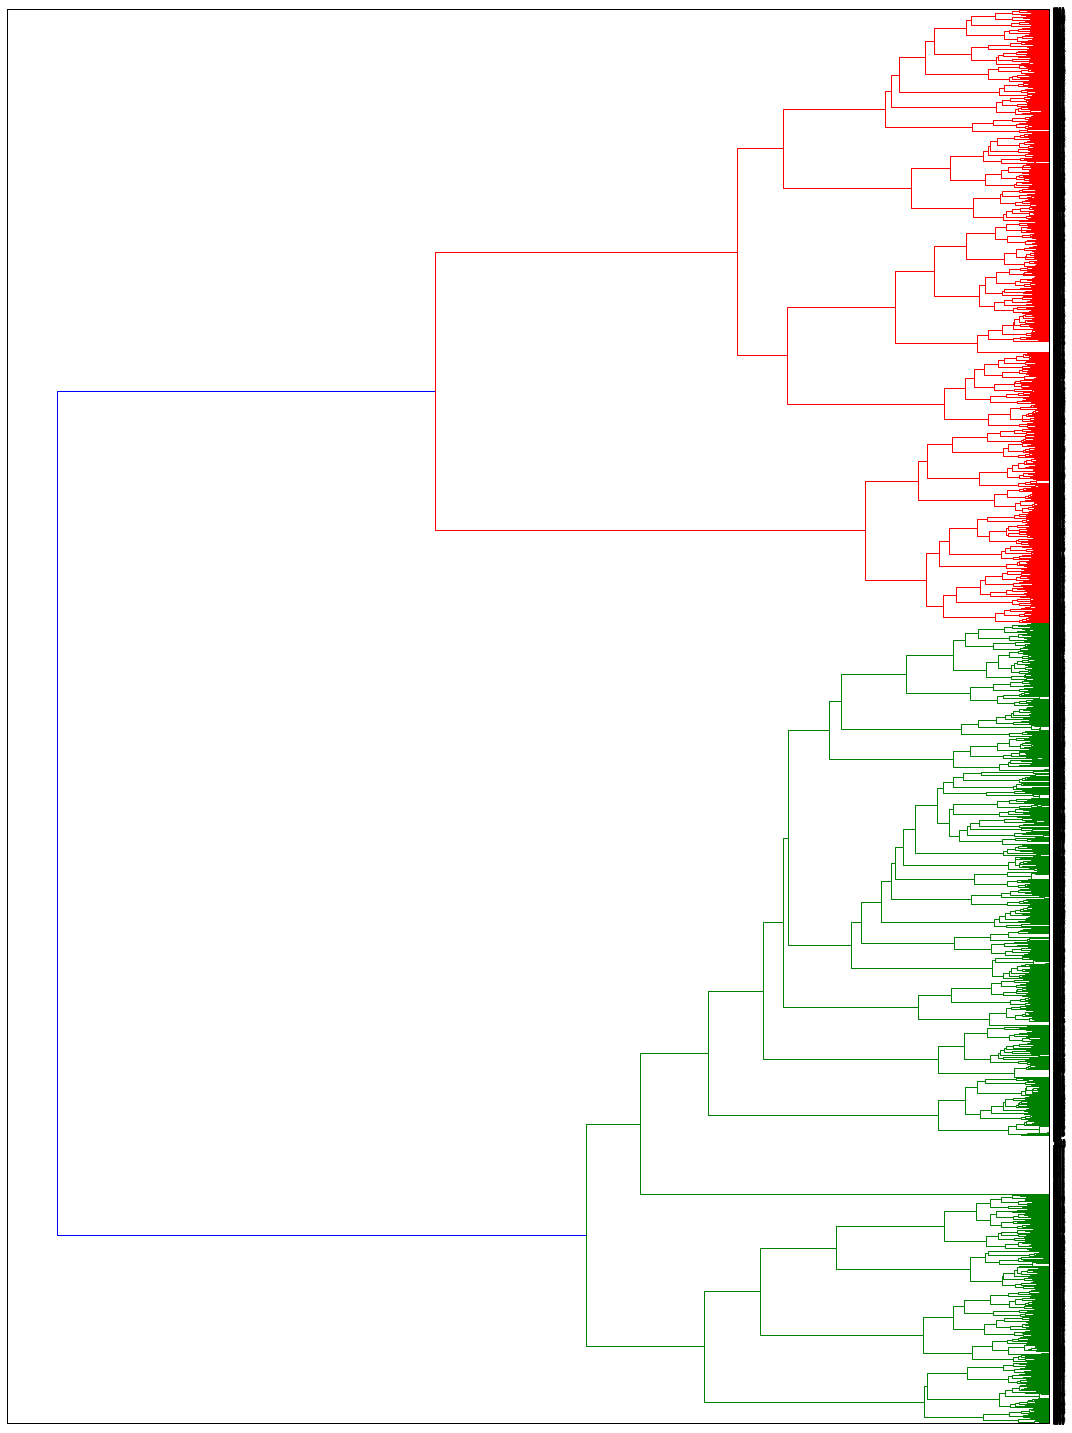

In [118]:
linkage_matrix = ward(dist)
fig, ax = plt.subplots(figsize=(15, 20))
ax = dendrogram(linkage_matrix, orientation="right")

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

## Repeat experiment with Named Entities (NE)

In [140]:
# assign hits to list of documents
# re-assign results from query
curr_res = res_all
for i, doc in enumerate(curr_res['hits']['hits']):
    try:
        signal_ents = doc['_source']['signal-entities']
    except:
        print i
        doc['_source']['signal-entities'] = []
documents_entities = [doc['_source']['signal-entities'] for doc in curr_res['hits']['hits']]

694


In [158]:
documents_entities_names = [" ".join([ent['surface-form'] for ent in doc_ent]) for doc_ent in documents_entities]

In [159]:
print documents_entities_names[0]

Gamma Knife Asia NEW YORK PRNewswire Radiation therapy radiation tumors ablate tumors noninvasive radiation Gamma Knife radiosurgery radiation therapy brain tumors arteriovenous malformations trigeminal neuralgia acoustic neuroma pituitary tumors Gamma Knife surgery radiation tumor cells brain radiation tumor cells cancer Gamma Knife Gamma Knife Gamma Knife Gamma Knife North America Gamma Knife cancer radiosurgery Gamma Knife cancer Gamma Knife Gamma Knife Canada North America Europe Germany France Italy Spain Gamma Knife Asia Gamma Knife cancer Latin America incidence cancer Gamma Knife Gamma Knife dynamics Gamma Knife Gamma Knife brain metastases brain tumor trigeminal neuralgia arteriovenous malformations Gamma Knife North America Europe Asia Latin America Gamma Knife Elekta Varian Medical Systems Nordion American sustainability Clare clare PR Newswire Sep. 1 Syndicated


In [130]:
from pprint import pprint

In [138]:
doc_0 = curr_res['hits']['hits'][1]
pprint(doc_0['_source']['signal-entities'])

[{u'annotation-probability': 0.8260869565217391,
  u'coherence': 0.18327089994716073,
  u'confidence': 0.5046789282344499,
  u'degree': 4,
  u'offset': 0,
  u'position': u'title',
  u'signal-type': u'none',
  u'surface-form': u'Johnny Manziel',
  u'types': None,
  u'wiki-title': u'Johnny_Manziel'},
 {u'annotation-probability': 0.7851851851851852,
  u'coherence': 0.1325442817564849,
  u'confidence': 0.45886473347083506,
  u'degree': 3,
  u'offset': 0,
  u'position': u'summary',
  u'signal-type': u'location',
  u'surface-form': u'BEREA, Ohio',
  u'types': {u'dbpedia': [u'PopulatedPlace',
                          u'Place',
                          u'City',
                          u'Settlement'],
             u'schema': [u'Place', u'City']},
  u'wiki-title': u'Berea,_Ohio'},
 {u'annotation-probability': 0.5167179704914553,
  u'coherence': 0.23216321947029456,
  u'confidence': 0.3744405949808749,
  u'degree': 7,
  u'offset': 22,
  u'position': u'summary',
  u'signal-type': u'none',
  u'

In [170]:
entity_vectorizer = TfidfVectorizer(max_features=200000, use_idf=True)

In [171]:
print documents_entities[0][0]['surface-form']

Gamma Knife


In [172]:
X_ent = entity_vectorizer.fit_transform(documents_entities_names)
print X_ent.shape

(10000, 33532)


In [173]:
num_clusters = 10
model = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=100, n_init=1)
model.fit(X_ent)
clusters = model.labels_.tolist()
joblib.dump(model, 'kmeans_entity.pkl')

['kmeans_entity.pkl', 'kmeans_entity.pkl_01.npy', 'kmeans_entity.pkl_02.npy']

In [179]:
print "Documents length", len(documents)
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = entity_vectorizer.get_feature_names()
for i in range(num_clusters):
    print "Cluster %d:" % i
    for ind in order_centroids[i, :15]:
        print ' %s' % terms[ind],
    print

Documents length 10000
Top terms per cluster:
Cluster 0:
 bath  zwolle  pence  kentucky  added  value  oem  small  fema  cycle  automotive  estuary  administration  life  industrial
Cluster 1:
 china  chinese  interest  stock  oil  dollar  market  beijing  us  rates  economy  reuters  markets  yuan  reserve
Cluster 2:
 new  the  australia  oil  facebook  york  twitter  american  south  united  president  london  energy  city  news
Cluster 3:
 india  google  apple  eu  amazon  refugees  lanka  minister  germany  sri  prime  hungary  european  iphone  test
Cluster 4:
 clinton  software  cloud  mobile  management  marketing  president  ceo  data  hillary  officer  financial  chief  digital  it
Cluster 5:
 god  marriage  pope  supreme  court  kentucky  same  licenses  sex  gay  abortion  county  rowan  sin  francis
Cluster 6:
 county  school  texas  high  san  chicago  attorney  insurance  illinois  allstate  district  marijuana  city  california  colorado
Cluster 7:
 newswire  pr  york  n

{0: 14, 1: 227, 2: 7798, 3: 332, 4: 525, 5: 97, 6: 474, 7: 202, 8: 202, 9: 119}
<type 'list'>   <type 'list'>


<Container object of 10 artists>

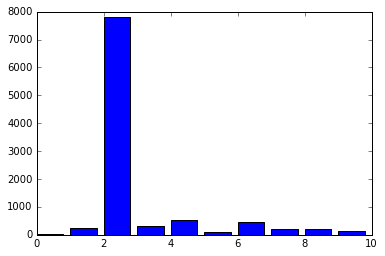

In [178]:
label_counts = {}
for label in model.labels_:
    try:
        label_counts[label] +=1
    except:
        label_counts[label] = 0
        
print label_counts
print type(label_counts.keys()), " ", type(label_counts.values())
        
plt.bar(label_counts.keys(), label_counts.values())

In [276]:
article_frame = pd.DataFrame([doc['_source'] for doc in res_all['hits']['hits']])
article_frame['cluster_label'] = model.labels_
article_frame['published_dt'] = article_frame['published'].apply(pd.to_datetime)

In [277]:
print article_frame.head(1)

         author                      canonical-source canonical-source-name  \
0  Liz McMillan  caaf6463-bb6b-422a-848f-fa2c8c74ee5d        Sys-Con Italia   

                                             content detected-language  \
0  NEW YORK, Sept. 1, 2015 /PRNewswire/ -- Radiat...                en   

  english-language-confidence      feed   id language  \
0           0.999997906887078  MOREOVER  NaN  English   

            language-confidences         ...          \
0  {u'en': u'0.999997906887078'}         ...           

                                  spotlight-entities  \
0  [{u'confidence': 0.395171647599, u'annotation-...   

                                   stanford-entities  \
0  [{u'start-offset': 36, u'surface-form': u'Asia...   

                             story-uuid  \
0  87c94bca-7864-44ac-be1b-e546a21acd9c   

                                             summary  \
0  NEW YORK, Sept. 1, 2015 /PRNewswire/ -- Radiat...   

                                      

In [278]:
print article_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 29 columns):
author                         4089 non-null object
canonical-source               9999 non-null object
canonical-source-name          9999 non-null object
content                        10000 non-null object
detected-language              9999 non-null object
english-language-confidence    9999 non-null object
feed                           9999 non-null object
id                             1 non-null object
language                       9999 non-null object
language-confidences           9999 non-null object
media-type                     10000 non-null object
model-scores                   9999 non-null object
moreover                       9999 non-null object
original-url                   9999 non-null object
published                      10000 non-null object
signal-entities                10000 non-null object
signal-importance              9999 non-null float64
source

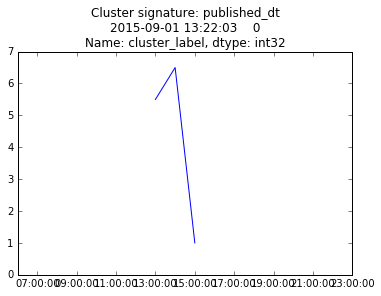

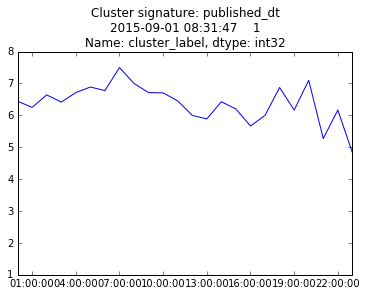

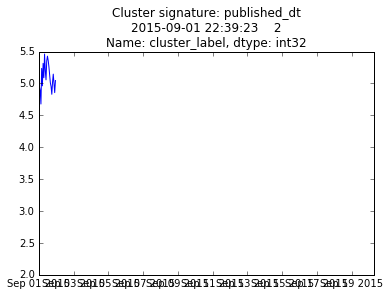

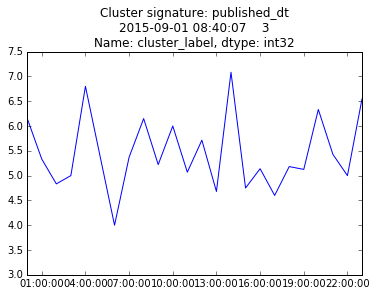

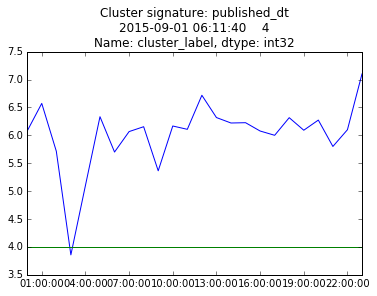

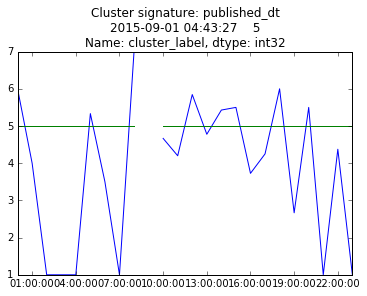

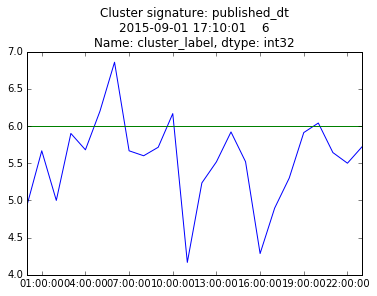

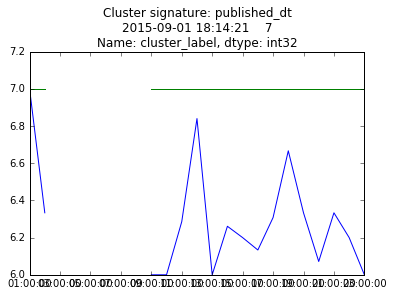

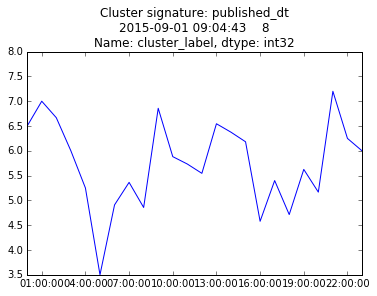

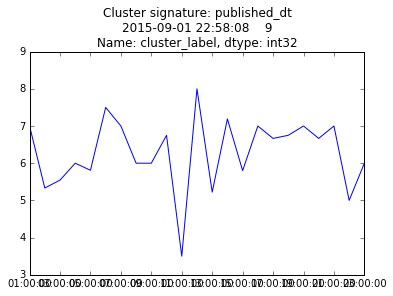

In [206]:
for name, group in article_frame.groupby('cluster_label'):
    group.index = group['published_dt']
    fig = plt.figure()
    plt.plot(group.resample('H'))
    plt.title("Cluster signature: " + str(group['cluster_label'].head(1)))

In [216]:
cluster_0 = model.cluster_centers_[0]
doc_0 = X_ent[0]

print cluster_0.shape
print doc_0.shape

(33532,)
(1, 33532)


In [236]:
D = euclidean_distances([cluster_0], doc_0) 
D1 = [euclidean_distances([cluster_0], doc)[0][0] for doc in X_ent[:10]]
# This would be the equivalent expression to the above scipy example, however note that euclidean_distances returns a matrix and not a scalar
print D[0][0]
print D1

1.08828362569
[1.0882836256871904, 1.0894095829671087, 1.089129737835419, 1.0839023024296732, 1.0822060340206285, 1.077592661755099, 1.0807303934403745, 1.0839192714437982, 1.0847874981154004, 1.0866353301622698]


In [266]:
print type(X_ent)
print type(X_ent.getrow(0))
embedding_rows = []
for i in range(0, 10000):
    embedding_rows.extend(X_ent.getrow(i))

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


In [279]:
article_frame['embedding'] = embedding_rows

In [280]:
print type(embedding_rows)

<type 'list'>


In [ ]:
article_frame['dist'] = euclidean_distances()

In [291]:
distances = []

for i, article in article_frame.iterrows():
    cluster =  [model.cluster_centers_[article['cluster_label']]]
    embedding = article['embedding']
    distances.append(euclidean_distances(cluster, embedding)[0][0])

article_frame['dist_to_centroid'] = distances

In [314]:
for name, group in article_frame.groupby('cluster_label'):
    print "Cluster: ", name
    smallest = group['dist_to_centroid'].nsmallest(2)
#     print smallest
#     print type(smallest)
    idx =  smallest.index.values
    print type(idx)
    print "Cluster terms: "
    for ind in order_centroids[name, :15]:
        print ' %s' % terms[ind]
    print "Summary of closest article to centroid: "
    for i in idx:
        print "Closest article: ", i
        print
        print article_frame.loc[i, 'content'][:1000]
        print 
    print 
    print

Cluster:  0
<type 'numpy.ndarray'>
Cluster terms: 
 bath
 zwolle
 pence
 kentucky
 added
 value
 oem
 small
 fema
 cycle
 automotive
 estuary
 administration
 life
 industrial
Summary of closest article to centroid: 
Closest article:  4016

Pedalling Book Tour Set To Arrive In Bath Next Week	Tuesday 1st September, 2015 - 09:36 | Posted by NOW Bath News Team 0 This September, Anna Hughes, author of Eat, Sleep, Cycle: A Bike Ride Around the Coast of Britain, will tour her book from Land’s End to John o’ Groats, stopping in Bath next Monday. She will visit cycle clubs, bookshops and cafes at various points along the 1000-mile route, promoting her book through talks, readings and signings. She’ll even be pedalling each mile as she peddles her wares. Anna’s passion is cycle touring, especially within the UK, and her talk is perfect for inspiring others to get out on two wheels and explore our beautiful island. Anna is an experienced and engaging speaker, having given talks to thousands of a